# 05. Model Evaluation & Analysis

1. **Detailed Performance Metrics** (ROC-AUC, Precision-Recall, F1-Score)
2. **Confusion Matrix & Threshold Tuning**
3. **Feature Importance**
4. **SHAP Value Analysis** 
5. **Calibration Analysis**


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap
from sklearn.metrics import (roc_auc_score, roc_curve, precision_recall_curve, 
                             auc, classification_report, confusion_matrix, 
                             accuracy_score, precision_score, recall_score, f1_score)
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)

print(" Libraries imported.")

 Libraries imported.


## 1. Load Data & Model

In [16]:
print(" Loading data and model...")

features_dir = "../data/features"
models_dir = "../models"

# Load processed training features
X_train_full = pd.read_csv(f"{features_dir}/X_train_smote.csv")
y_train_full = pd.read_csv(f"{features_dir}/y_train_smote.csv")['TARGET']

# Load Best Model
try:
    model = joblib.load(f"{models_dir}/best_model_lgbm.pkl")
    print(" Model loaded successfully.")
except FileNotFoundError:
    print(" Model file not found! Please run 04_modeling_training.ipynb first.")
    
print(f"Data Shape: {X_train_full.shape}")

 Loading data and model...
 Model loaded successfully.
Data Shape: (424029, 200)


## 2. Re-create Validation Set


In [17]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
)

print(f"Validation Set: {X_val.shape}")

Validation Set: (84806, 200)


## 3. Predictions

In [19]:
print(" Generating predictions...")
y_pred_prob = model.predict_proba(X_val)[:, 1]
y_pred_default = model.predict(X_val) # Default threshold 0.5

 Generating predictions...


## 4. Performance Metrics (Default Threshold)

In [20]:
print("Classification Report (Threshold=0.5):")
print(classification_report(y_val, y_pred_default))

roc = roc_auc_score(y_val, y_pred_prob)
print(f"ROC-AUC Score: {roc:.4f}")

Classification Report (Threshold=0.5):
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56537
           1       1.00      0.81      0.90     28269

    accuracy                           0.94     84806
   macro avg       0.96      0.91      0.93     84806
weighted avg       0.94      0.94      0.94     84806

ROC-AUC Score: 0.9602


## 5. ROC Curve & Precision-Recall Curve

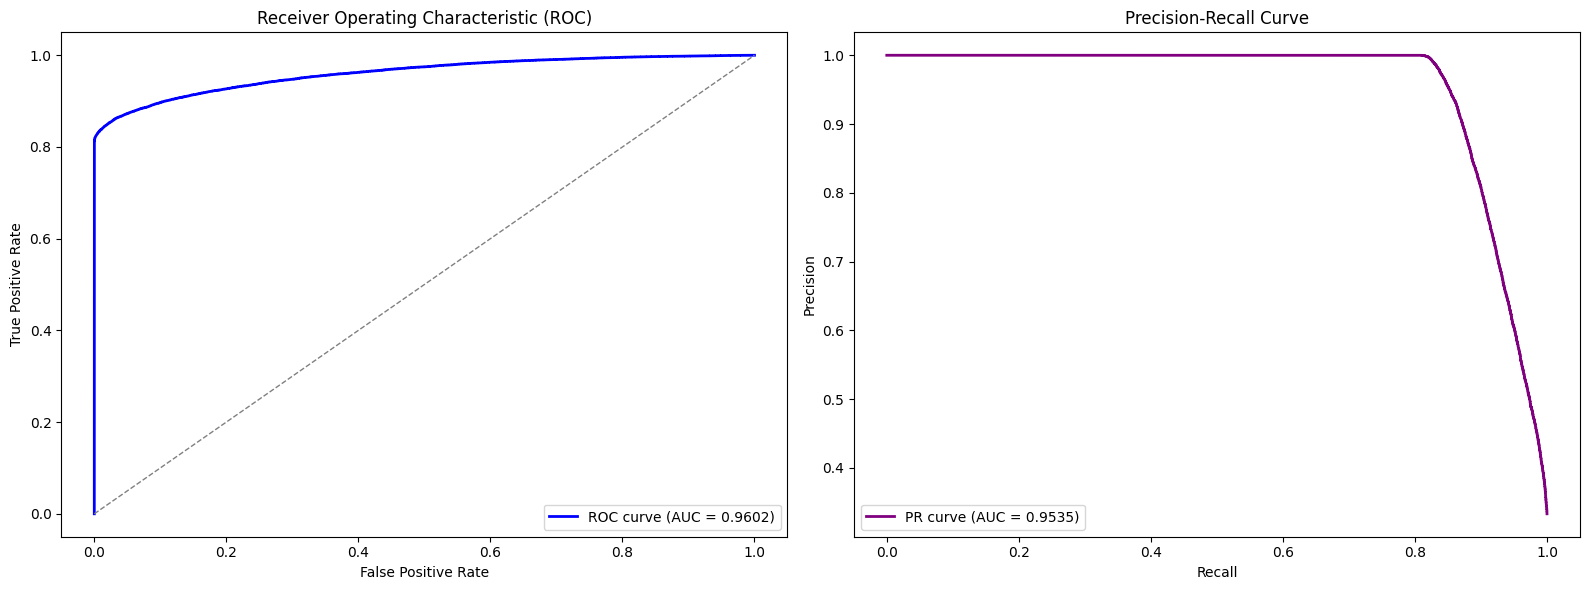

In [21]:
fpr, tpr, thresholds_roc = roc_curve(y_val, y_pred_prob)
precision, recall, thresholds_pr = precision_recall_curve(y_val, y_pred_prob)
pr_auc = auc(recall, precision)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curve
axes[0].plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc:.4f})')
axes[0].plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('Receiver Operating Characteristic (ROC)')
axes[0].legend(loc="lower right")

# Precision-Recall Curve
axes[1].plot(recall, precision, color='purple', lw=2, label=f'PR curve (AUC = {pr_auc:.4f})')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve')
axes[1].legend(loc="lower left")

plt.tight_layout()
plt.show()

## 6. Threshold Tuning
Since this is credit scoring, False Negatives (missing a defaulter) are usually more costly than False Positives (rejecting a good customer). We might want to adjust the threshold to increase Recall, even if Precision drops slightly.

In [22]:
# Find threshold that maximizes F1-Score
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
best_thresh = thresholds_pr[ix]
print(f"Best Threshold (Max F1): {best_thresh:.4f}")

# Apply new threshold
y_pred_opt = (y_pred_prob >= best_thresh).astype(int)

print("\nClassification Report (Optimized Threshold):")
print(classification_report(y_val, y_pred_opt))

Best Threshold (Max F1): 0.3677

Classification Report (Optimized Threshold):
              precision    recall  f1-score   support

           0       0.92      0.99      0.96     56537
           1       0.99      0.83      0.90     28269

    accuracy                           0.94     84806
   macro avg       0.95      0.91      0.93     84806
weighted avg       0.94      0.94      0.94     84806



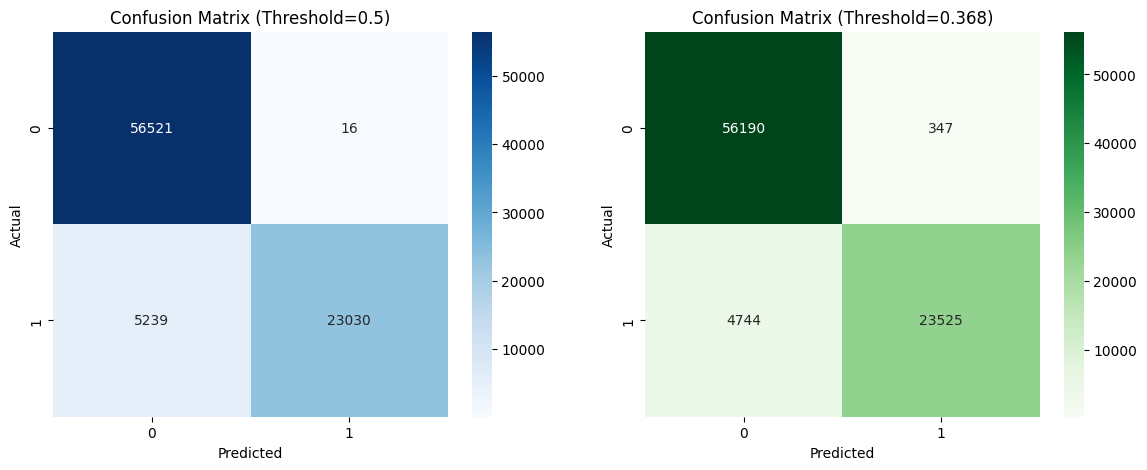

In [23]:
# Confusion Matrix Comparison
cm_def = confusion_matrix(y_val, y_pred_default)
cm_opt = confusion_matrix(y_val, y_pred_opt)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(cm_def, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix (Threshold=0.5)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(cm_opt, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title(f'Confusion Matrix (Threshold={best_thresh:.3f})')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.show()

## 7. Feature Importance Analysis
Understanding which features drive the model decisions.

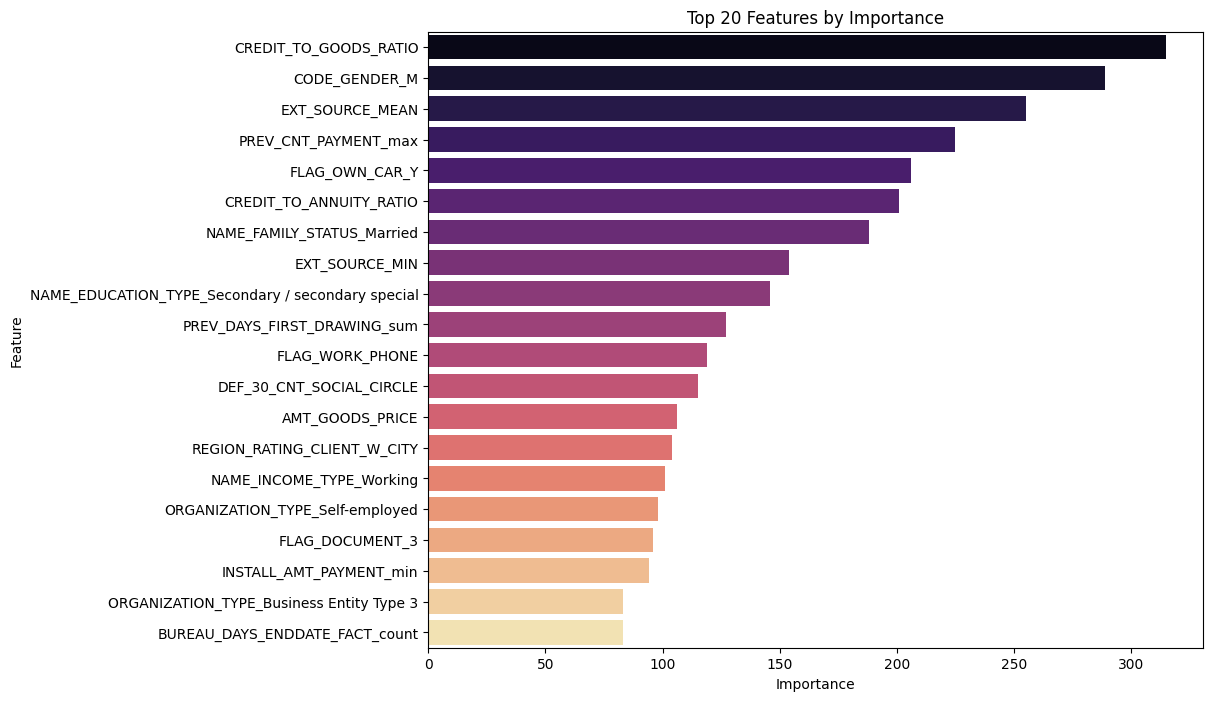

In [24]:
feature_imp = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_imp.head(20), palette='magma')
plt.title('Top 20 Features by Importance')
plt.show()

## 8. SHAP Value Analysis (Model Interpretability)
SHAP (SHapley Additive exPlanations) values break down a prediction to show the impact of each feature.

 Calculating SHAP values... (this may take a while)


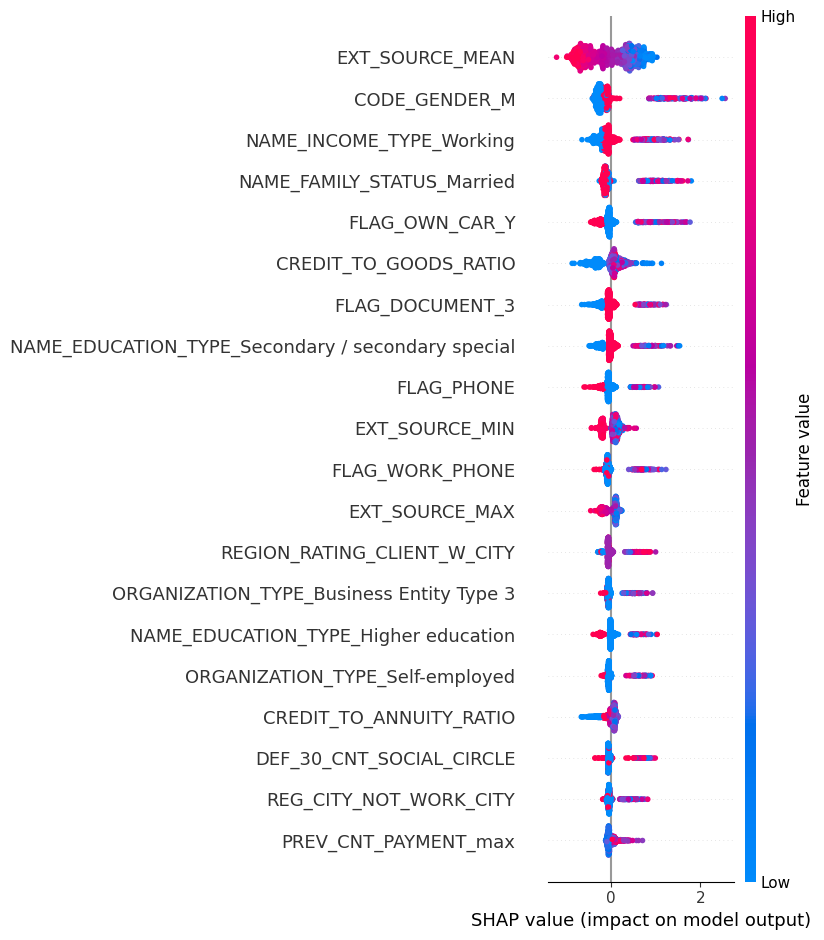

In [29]:
# Explain model predictions using SHAP
print(" Calculating SHAP values... (this may take a while)")
explainer = shap.TreeExplainer(model)

# Calculate SHAP values for a subset of the validation data to speed up plotting
sample_size = min(1000, X_val.shape[0])
X_val_sample = X_val.sample(sample_size, random_state=42)
shap_values = explainer.shap_values(X_val_sample)


if isinstance(shap_values, list):
    shap_vals_target = shap_values[1]
else:
    shap_vals_target = shap_values

# Summary Plot 
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_vals_target, X_val_sample, plot_type="dot")
plt.show()

## 9. Calibration Curve
Checks if the predicted probabilities reflect true likelihoods.

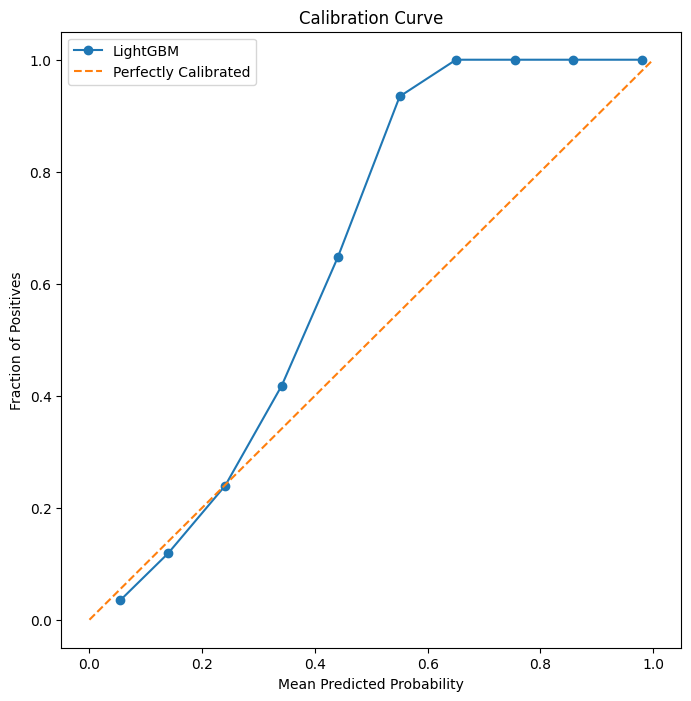

In [26]:
prob_true, prob_pred = calibration_curve(y_val, y_pred_prob, n_bins=10)

plt.figure(figsize=(8, 8))
plt.plot(prob_pred, prob_true, marker='o', label='LightGBM')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend()
plt.show()